
<div class="alert alert-block alert-info">
   <h2 align="center"> <center><b> Reinforcement Learning Assignment 1 - The Reinforcement Learning Framework</b></center></h2>

<br>
<center><font size="3">This notebook is a part of teaching material for ELEC-E8125</font></center>
<center><font size="3">Sep 4, 2023 - Nov 30, 2023</font></center>
<center><font size="3">Aalto University</font></center>
</div>


<a id='TOC'></a>

<div class="alert alert-block alert-success">
    
# Table of contents
* <a href='#1.'> 1. Introduction </a>
* <a href='#1.1'> 1.1 Learning Objectives </a>
* <a href='#1.2'> 1.2 Code Structure & Files </a>
* <a href='#2.'> 2. Cartpole</a>
* <a href='#3.'> 3. Reacher</a>
* <a href='#4.'> 4. Submitting </a>
* <a href='#4.1'> 4.1 Feedback </a>
* <a href='#5.'> References</a>

<a href='#T1'><b>Student Task 1.</b> Training a Model for Simple Cartpole Environment (10 points)</a>\
<a href='#Q1'><b>Student Question 1.1</b> Learning (10 points)</a>\
<a href='#T2'><b>Student Task 2.</b> Investigating Training Performance (10 points) </a>\
<a href='#Q2'><b>Student Question 2.1</b> Analysis of Training Performance (15 points) </a>\
<a href='#Q3'><b>Student Question 2.2</b> Stochasticity (10 points) </a>\
<a href='#T3'><b>Student Task 3.</b> Reward Functions (20 points) </a>\
<a href='#T4'><b>Student Task 4.</b> Visualizing Behavior (10 points) </a>\
<a href='#Q4'><b>Student Question 4.1</b> Achieved Peformance (5 points)\
<a href='#Q5'><b>Student Question 4.2</b> Analysis of Behaviour (10 points)</a>
    
**Total Points:** 100

# 1. Introduction <a id='1.'></a>
In this exercise we will take a first look at a reinforcement learning environment, its components and modify the reward function of a simple agent.

In this notebook two environments are used: Cartpole and Reacher. The cartpole environment is taken from [OpenAI's Gym library](https://www.gymlibrary.dev/). The reacher environment is custom made (and defined in ```reacher.py```) but utilizes the Gym API.

## 1.1 Learning Objectives: <a id='1.1'></a>
- To become familiar with assignment structure and the agent-environment relationshp
- To understand the effects of stochasticity
- To understand and explore the effects of task definition

## 1.2 Code Structure & Files <a id='1.2'></a>

The ```train.py``` file instantiates the environment and the RL agent that acts in it. The ```agent.py``` file contains the implementation of a simple reinforcement learning agent; for the sake of this exercise, you can assume it to be a black box (you don’t need to understand how it works, although you are encouraged to study it in more detail). You don’t have to edit any other file other than ```ex1.ipynb``` to complete this exercise.
```
├───cfg                  # Config files for environments e.g. define the maximum number of steps in an episode.
├───imgs                 # Images used in notebook
├───results 
│   ├───logging          # Contains logged data
│   ├───model            # Contains the policies learned
│   └───video            # Contains videos for each environment
│       └───CartPole-v0
│       │  └───test      # Videos saved during testing
│       │  └───train     # Videos saved during training
│       └───SpinningReacher-v0
│           └───test
│           └───train
├───wandb                # Data saved for wandb
│   ex1.ipynb            # Main assignment file containing tasks <---------
│   feedback.ipynb       # Please give feedback in here
│   README.ipynb         # This file
│   agent.py             # Contains functions that govern the policy
│   reacher.py           # Defines the reacher environment
│   train.py             # Contains training and testing functions
│   utils.py             # Contains useful functions 
```

Please consult ```README.md``` for more details the assignments.

The assignments use wandb to visualize data. You need to set Wandb up and login using the command below.

In [1]:
! wandb login 34902633b7a1636949fce4d030bcc5c861e19bc5 # Insert API key here. You can get your API key from https://wandb.ai/authorize

wandb: Appending key for api.wandb.ai to your netrc file: /home/nguyenb5/.netrc


In [2]:
from pathlib import Path # to find directory
work_dir = Path().cwd()/'results'
import os
os.environ['WANDB_NOTEBOOK_NAME'] = str(Path().cwd()/'ex1.ipynb') # Detects notebook for wandb

import train as t # for training
import utils as u # helper functions

import numpy as np # The numpy library can be used for math functions
import torch # Used to manage policy and learning
from IPython.display import Video, display, HTML # to display videos

# 2. Cartpole <a id='2.'></a>

The Cartpole environment consists of a cart and a pole mounted on top of it, as shown in Figure 1. The cart can move either to the left or to the right. The goal is to balance the pole in a vertical position in order to prevent it from falling down. The cart should also stay within limited distance from the center (trying to move outside screen boundaries is considered a failure).

<figure>
<img src="imgs/cartpole.png" width="400px">
<figcaption style="text-align: center"> Figure 1: The Cartpole environment  </figcaption>
</figure>

The state and the observation are four element vectors:

$$
o=s=\left(\begin{array}{c}
x \\
\dot{x} \\
\theta \\
\dot{\theta}
\end{array}\right) \text {, }
$$

where $x$ is the position of the cart, $\dot{x}$ is its velocity, $\theta$ is the angle of the pole w.r.t. the vertical axis, and $\dot{\theta}$ is the angular velocity of the pole.

In the standard formulation, a reward of 1 is given for every timestep the pole remains balanced. Upon failing (the pole falls) or completing the task, an episode is finished.

The training script will record videos of the agent’s learning progress during training, and the recorded videos are saved to ```results/video/CartPole-v0/train```. By default, the training information is saved to ```results/logging/CartPole-v0_logging.pkl``` as well as on cloud via wandb. When the training is finished, the models are saved to ```results/model/Cartpole-v0_params.pt```. The models can be tested by setting ```testing=true``` in ```cfg_args```, and if the models are saved to a different path, you can use ```model_path=<YOUR MODEL PATH>``` to indicate it. Videos of the agent’s behaviour during testing are saved to ```results/video/CartPole-v0/test```.

<a id='T1'></a>
<div class=" alert alert-warning">
    <h3><b>Student Task 1.</b> Training a Model for Simple Cartpole Environment (10 points) </h3> 

This task requires you to train a model for the cartpole environment with 100 timesteps per episode and then report the training plot using 'Weights \& Biases'. Then test the model for 1000 timesteps and report average reward. To do this, you can simply run the code in the cells below. 

To see a full list of options that can be passed through ```cfg_args``` consult the configuation file found in ```cfg/```.

- **1st:** setup 'Weights \& Biases', check the README for help. 
- **2nd:** Run training over 100 steps per episode by using ```t.train``` function. See the cell below. 
- **3rd:** Export the training plot ```episodesep_reward``` from wandb (see ```README.md```) and attach below.
- **4th:** Run testing over 1000 steps by using ```t.test``` function. See the cell below. See the cell below. Notice ```max_episode_steps``` parameter. 
- **5th:** Report the average reward after testing the model.
    
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>


In [31]:
t.train(cfg_path=Path().cwd()/'cfg'/'cartpole_v1.yaml', 
        cfg_args=dict(seed=1, max_episode_steps=100, silent=True)) # < 5 mins

Numpy/Torch/Random Seed:  1


Configuration Settings: {'exp_name': 'ex1', 'seed': 1, 'env_name': 'CartPole-v1', 'max_episode_steps': 100, 'train_episodes': 500, 'batch_size': 64, 'min_update_samples': 2000, 'testing': False, 'model_path': 'default', 'save_video': True, 'save_model': True, 'save_logging': True, 'silent': True, 'use_wandb': True, 'run_suffix': 0}
Training device: cpu
Observation space dimensions: 4
Action space dimensions: 2

Updating the policy...
Updating finished!
Updating the policy...
Updating finished!
Updating the policy...
Updating finished!
Updating the policy...
Updating finished!
Updating the policy...
Updating finished!
Updating the policy...
Updating finished!
Updating the policy...
Updating finished!
Updating the policy...
Updating finished!
Updating the policy...
Updating finished!
Updating the policy...
Updating finished!
Updating the policy...
Updating finished!
Updating the policy...
Updating finished!
Updating the policy...
Updating finished!
Updating the policy...
Updating finishe

The training figure of the CartPole environment is:

<figure>
<img src="imgs/Task1.png" width="800px">
<figcaption style="text-align: center"> Figure 2: The episode rewards plot for the trained model  </figcaption>
</figure>

The command below will evaluate the trained model in 10 episodes and report the average reward (and episode length) for these 10 episodes.

In [32]:
t.test(episodes=10, 
       cfg_path=Path().cwd()/'cfg'/'cartpole_v1.yaml', 
       cfg_args=dict(testing=True, seed=None, max_episode_steps=1000, use_wandb=False))

Numpy/Torch/Random Seed:  501
Loading model from /notebooks/rl2023/ex1/results/model/CartPole-v1_params.pt ...
Testing...
Test ep reward: 137.0 seed: 88
Test ep reward: 127.0 seed: 672
Test ep reward: 131.0 seed: 680
Test ep reward: 127.0 seed: 592
Test ep reward: 135.0 seed: 481
Test ep reward: 137.0 seed: 78
Test ep reward: 147.0 seed: 735
Test ep reward: 156.0 seed: 852
Test ep reward: 132.0 seed: 694
Test ep reward: 126.0 seed: 965
Average test reward: 135.5 episode length: 135.5


The average reward after testing the model is 135.5

The agent acting in the environment can be seen using the following command. Change the ```path``` to pick the episode you want to visualize. Bear in mind by default video saving for training is taken every 50 episodes.

In [3]:
# Train Result
video_dir = work_dir/'video'/'CartPole-v1'/'train'

# List all MP4 files in the directory
mp4_files = [file for file in os.listdir(video_dir) if file.endswith(".mp4")]
frame_colors = ['#FF5733', '#33FF57', '#5733FF', '#FFFF33', '#33FFFF', '#FF33FF']
# Display each MP4 file
for i, mp4_file in enumerate(mp4_files):
    video_path = os.path.join(video_dir, mp4_file)
    video = Video(video_path, embed=True, html_attributes="loop autoplay", width=200, height=100)
    frame_color = frame_colors[i % len(frame_colors)]
    video_frame = HTML(f'<div style="width: 200px; height: 100px;; border: 1px solid #FF5733;">{video._repr_html_()}</div>')
    print("test/",mp4_file)
    display(video_frame)

test/ ex1-episode-0.mp4


test/ ex1-episode-50.mp4


test/ ex1-episode-100.mp4


test/ ex1-episode-150.mp4


test/ ex1-episode-200.mp4


test/ ex1-episode-250.mp4


test/ ex1-episode-300.mp4


test/ ex1-episode-350.mp4


test/ ex1-episode-400.mp4


test/ ex1-episode-450.mp4


test/ ex1-episode-500.mp4


In [4]:
# Test Result

video_dir = work_dir/'video'/'CartPole-v1'/'test'

# List all MP4 files in the directory
mp4_files = [file for file in os.listdir(video_dir) if file.endswith(".mp4")]
frame_colors = ['#FF5733', '#33FF57', '#5733FF', '#FFFF33', '#33FFFF', '#FF33FF']
# Display each MP4 file
for i, mp4_file in enumerate(mp4_files):
    video_path = os.path.join(video_dir, mp4_file)
    video = Video(video_path, embed=True, html_attributes="loop autoplay", width=200, height=100)
    frame_color = frame_colors[i % len(frame_colors)]
    video_frame = HTML(f'<div style="width: 200px; height: 100px;; border: 1px solid #5733FF;">{video._repr_html_()}</div>')
    print("test/",mp4_file)
    display(video_frame)

test/ ex1-episode-0.mp4


test/ ex1-episode-1.mp4


test/ ex1-episode-2.mp4


test/ ex1-episode-3.mp4


test/ ex1-episode-4.mp4


test/ ex1-episode-5.mp4


test/ ex1-episode-6.mp4


test/ ex1-episode-7.mp4


test/ ex1-episode-8.mp4


test/ ex1-episode-9.mp4


test/ ex1_seed_100-episode-1.mp4


test/ ex1_seed_100-episode-0.mp4


test/ ex1_seed_200-episode-0.mp4


test/ ex1_seed_300-episode-0.mp4


test/ ex1_seed_400-episode-0.mp4


test/ ex1_seed_500-episode-0.mp4


test/ ex1_seed_100-episode-2.mp4


test/ ex1_seed_100-episode-3.mp4


test/ ex1_seed_100-episode-4.mp4


test/ ex1_seed_100-episode-5.mp4


test/ ex1_seed_100-episode-6.mp4


test/ ex1_seed_100-episode-7.mp4


test/ ex1_seed_100-episode-8.mp4


test/ ex1_seed_100-episode-9.mp4


test/ ex1_seed_200-episode-1.mp4


test/ ex1_seed_200-episode-2.mp4


test/ ex1_seed_200-episode-3.mp4


test/ ex1_seed_200-episode-4.mp4


test/ ex1_seed_200-episode-5.mp4


test/ ex1_seed_200-episode-6.mp4


test/ ex1_seed_200-episode-7.mp4


test/ ex1_seed_200-episode-8.mp4


test/ ex1_seed_200-episode-9.mp4


test/ ex1_seed_300-episode-1.mp4


test/ ex1_seed_300-episode-2.mp4


test/ ex1_seed_300-episode-3.mp4


test/ ex1_seed_300-episode-4.mp4


test/ ex1_seed_300-episode-5.mp4


test/ ex1_seed_300-episode-6.mp4


test/ ex1_seed_300-episode-7.mp4


test/ ex1_seed_300-episode-8.mp4


test/ ex1_seed_300-episode-9.mp4


test/ ex1_seed_400-episode-1.mp4


test/ ex1_seed_400-episode-2.mp4


test/ ex1_seed_400-episode-3.mp4


test/ ex1_seed_400-episode-4.mp4


test/ ex1_seed_400-episode-5.mp4


test/ ex1_seed_400-episode-6.mp4


test/ ex1_seed_400-episode-7.mp4


test/ ex1_seed_400-episode-8.mp4


test/ ex1_seed_400-episode-9.mp4


test/ ex1_seed_500-episode-1.mp4


test/ ex1_seed_500-episode-2.mp4


test/ ex1_seed_500-episode-3.mp4


test/ ex1_seed_500-episode-4.mp4


test/ ex1_seed_500-episode-5.mp4


test/ ex1_seed_500-episode-6.mp4


test/ ex1_seed_500-episode-7.mp4


test/ ex1_seed_500-episode-8.mp4


test/ ex1_seed_500-episode-9.mp4


<a id='Q1'></a>
<div class=" alert alert-warning">
    <h3><b>Student Question 1.1</b> Learning (10 points) </h3> 

Test the trained model from Task 1 five times with different random seeds. Did the same model, trained to balance for 100 timesteps, learn to always balance the pole for 1000 timesteps? Why/why not?
    
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>


In [35]:
t.test(episodes=10, 
       cfg_path=Path().cwd()/'cfg'/'cartpole_v1.yaml', 
       cfg_args=dict(testing=True, exp_name="ex1_seed_100", seed=100, max_episode_steps=1000, silent=True, use_wandb=False))

t.test(episodes=10, 
       cfg_path=Path().cwd()/'cfg'/'cartpole_v1.yaml', 
       cfg_args=dict(testing=True, exp_name="ex1_seed_200", seed=200, max_episode_steps=1000, silent=True, use_wandb=False))

t.test(episodes=10, 
       cfg_path=Path().cwd()/'cfg'/'cartpole_v1.yaml', 
       cfg_args=dict(testing=True, exp_name="ex1_seed_300", seed=300, max_episode_steps=1000, silent=True, use_wandb=False))

t.test(episodes=10, 
       cfg_path=Path().cwd()/'cfg'/'cartpole_v1.yaml', 
       cfg_args=dict(testing=True, exp_name="ex1_seed_400", seed=400, max_episode_steps=1000, silent=True, use_wandb=False))

t.test(episodes=10, 
       cfg_path=Path().cwd()/'cfg'/'cartpole_v1.yaml', 
       cfg_args=dict(testing=True, exp_name="ex1_seed_500", seed=500, max_episode_steps=1000, silent=True, use_wandb=False))


Numpy/Torch/Random Seed:  100
Loading model from /notebooks/rl2023/ex1/results/model/CartPole-v1_params.pt ...
Testing...
Test ep reward: 129.0 seed: 100
Test ep reward: 129.0 seed: 100
Test ep reward: 129.0 seed: 100
Test ep reward: 129.0 seed: 100
Test ep reward: 129.0 seed: 100
Test ep reward: 129.0 seed: 100
Test ep reward: 129.0 seed: 100
Test ep reward: 129.0 seed: 100
Test ep reward: 129.0 seed: 100
Test ep reward: 129.0 seed: 100
Average test reward: 129.0 episode length: 129.0
Numpy/Torch/Random Seed:  200
Loading model from /notebooks/rl2023/ex1/results/model/CartPole-v1_params.pt ...
Testing...
Test ep reward: 124.0 seed: 200
Test ep reward: 124.0 seed: 200
Test ep reward: 124.0 seed: 200
Test ep reward: 124.0 seed: 200
Test ep reward: 124.0 seed: 200
Test ep reward: 124.0 seed: 200
Test ep reward: 124.0 seed: 200
Test ep reward: 124.0 seed: 200
Test ep reward: 124.0 seed: 200
Test ep reward: 124.0 seed: 200
Average test reward: 124.0 episode length: 124.0
Numpy/Torch/Random

I run the testing for seed values of 100, 200, 300, 400, 500 and the results are shown above

Out of the 5 random seeds, the testing reward using falls in the range of 130-140. Therefore, my answer is that the pole is highly unlikely to be balanced for 1000 timesteps given any seed values. The reason for the failures is because the pole is only trained for 100 timesteps, which we cannot guarantee its balance in the step 10 times more than the training timesteps. The cause of failure is most often related to the cartpole moving outside of the screen.

<a id='T2'></a>
<div class=" alert alert-warning">
    <h3><b>Student Task 2.</b> Investigating Training Performance (10 points) </h3> 

Repeat the experiment in Task 1 five times, each time training the model from scratch with 100 timesteps and testing it for 1000 timesteps. Use a different seed number for each training/testing cycle. You can use the box below to write a small script to do this. Use the result textbox below to report the average test reward for each repeat. 
    
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>


In [52]:
for seed_number in [100, 200, 300, 400, 500]:
    # Define the original and temporary file paths
    original_path = Path().cwd()/"results"/"model"/"CartPole-v1_params.pt"
    temp_path = Path().cwd()/"results"/"model"/"CartPole-v1_params_temp.pt"

    if original_path.exists():
        original_path.rename(temp_path)

    t.train(cfg_path=f"{Path().cwd()}/cfg/cartpole_v1.yaml",  
            cfg_args=dict(exp_name=f"ex1_task2_seed_{seed_number}", 
                          #model_path=f"CartPole-v1_Task2_seed_{seed_number}.yaml",
                          train_episodes=200, save_video=False, save_logging=False,
                          seed=seed_number, max_episode_steps=100,
                          silent=True, use_wandb=False)) 

    t.test(episodes=10, 
           cfg_path=f"{Path().cwd()}/cfg/cartpole_v1.yaml", 
           cfg_args=dict(testing=True, 
                         exp_name=f"ex1_task2_seed_{seed_number}", 
                         seed=seed_number, max_episode_steps=1000, 
                         save_video=False,
                         silent=True, use_wandb=False))

    new_path = Path().cwd()/"results"/"model"/f"CartPole-v1_params_ex1_task2_seed_{seed_number}.pt"

    if original_path.exists():
        original_path.rename(new_path)

    temp_path.rename(original_path)

Numpy/Torch/Random Seed:  100
Configuration Settings: {'exp_name': 'ex1_task2_seed_100', 'seed': 100, 'env_name': 'CartPole-v1', 'max_episode_steps': 100, 'train_episodes': 200, 'batch_size': 64, 'min_update_samples': 2000, 'testing': False, 'model_path': 'default', 'save_video': False, 'save_model': True, 'save_logging': False, 'silent': True, 'use_wandb': False, 'run_suffix': 0}
Training device: cpu
Observation space dimensions: 4
Action space dimensions: 2

Updating the policy...
Updating finished!
Updating the policy...
Updating finished!
Model saved to /notebooks/rl2023/ex1/results/model/CartPole-v1_params.pt
------Training finished.------
Numpy/Torch/Random Seed:  100
Loading model from /notebooks/rl2023/ex1/results/model/CartPole-v1_params.pt ...
Testing...
Test ep reward: 629.0 seed: 100
Test ep reward: 629.0 seed: 100
Test ep reward: 629.0 seed: 100
Test ep reward: 629.0 seed: 100
Test ep reward: 629.0 seed: 100
Test ep reward: 629.0 seed: 100
Test ep reward: 629.0 seed: 100
T

I run the training and testing for different seed values of 100, 200, 300, 400, 500 and these are the average test rewards (note: I only train for 200 episdoes instead of 500 episodes so it can differ from your model solution)

Seed 100: Average test reward: 629.0

Seed 200: Average test reward: 170.0

Seed 300: Average test reward: 76.0

Seed 400: Average test reward: 158.0

Seed 500: Average test reward: 495.0

<a id='Q2'></a>
<div class=" alert alert-warning">
    <h3><b>Student Question 2.1</b> Analysis of Training Performance (15 points) </h3> 

Are the behavior and performance of the trained models the same every time? Why/why not? Analyze the causes briefly.
    
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>


As we can see from above, each time I run with a different seed number, the average test reward will change by standard deviation of 200. Therefore, the behavior and performance of the trained models will differ every time a different seed is used. This is because the training environment is stochastic by nature. The environment initial state is different each time and the transition action for each time step is also probabilistic for different seed number, which explains the underlying stochasticity of the model. 

<a id='Q3'></a>
<div class=" alert alert-warning">
    <h3><b>Student Question 2.2</b> Stochasticity (10 points) </h3> 

What are the implications of this stochasticity, when it comes to comparing reinforcement learning algorithms to each other? Please explain.
    
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>


The stochasticity will first cause the variance in performance of the RL models, which we can see from above that each seed number results in a different average testing reward. Secondly, this randomness also causes the initial state to vary significantly, which many RL models are highly sensitive to. Additionally, the randomness may make the performance of RL models harder to quantify, as it is often unsure whether good performance is due to luck or due to the underlying algorithm. Therefore, when we compare RL algorithms, we should run multiple trials with different seed number and record the average performance plus its standard deviation (like Task 1). Additionally, we should use the same seed for comparing RL models to reproduce the same randomness and make them start from the same initial states so their performance is easier to compare than starting from different initial states. 

# Reacher <a id='3.'></a>

Now we will focus on designing a reward function for a different environment, the Reacher environment, where a two-joint manipulator needs to reach a goal (see Figure 2).

<figure>
<img src="imgs/reacher.png" width="200px">
<figcaption style="text-align: center"> Figure 2: The Reacher environment  </figcaption>
</figure>

The Cartesian ($x$, $y$) position of the end-effector of the manipulator can be determined following the equation:

$$
 x = L_1 \sin(\theta_0)+L_2 \sin(\theta_0+\theta_1)\\
 y = -L_1 \cos(\theta_0)-L_2 \cos(\theta_0+\theta_1)
$$

where $L1 = 1$, $L2 = 1$ are the lengths, and $\theta_0$, $\theta_1$ the joint angles of the first and second links respectively. The state (and observation) in this environment is the two element vector:

$$
o=s=\left(\begin{array}{c}
\theta_0 \\
\theta_1 \\
\end{array}\right) \text {, }
$$

The action space now consists of 5 "options"; 4 correspond rotating the first/second joint left/right, and the final one performs no motion at all (the configuration doesn’t change). The episode terminates when the agent reaches the target position, marked in red. Now, let us design a custom reward function and use it for training the RL agent.

<a id='T3'></a>
<div class=" alert alert-warning">
    <h3><b>Student Task 3.</b> Reward Functions (20 points) </h3> 

Below two classes are shown that modify the reward function of the reacher function provided in ```reacher.py```. Edit the function ```get_reward``` _below_ (not in ```reacher.py```) in both classes. For each class, write a reward function to incentivise the agent to learn the following behaviors:

Class 1) ```SpinningReacherEnv```: Keep the manipulator rotating clockwise continuously (w.r.t. angle θ_0). You can use a lower number of training episodes for this, e.g. train(cfg_args=dict(env_name='SpinningReacher-v0', train_episodes=200), overrides=['env=reacher_v1'])

Class 2) ```TargetReacherEnv```: Reach the goal point located in x = [1.0,1.0] (marked in red). Use at least 500 training episodes.
    
Train one model for each behavior. 

**Hint:** Use the observation vector to get the quantities required to compute the new reward (such as the position of the manipulator). You can get the Cartesian position of the end-effector with ```self.get_cartesian_pos(state)```.
            
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>


In [9]:
from reacher import ReacherEnv
from typing import Optional
from gymnasium.envs.registration import register

class SpinningReacherEnv(ReacherEnv):
    def __init__(self, render_mode: Optional[str] = None, max_episode_steps=200):
        super().__init__(render_mode=render_mode, max_episode_steps=max_episode_steps)

    def get_reward(self, prev_state, action, next_state):
        # TODO: Task 3: Implement and test the second reward function
        ########## Your code starts here ##########
        # Keep the manipulator rotating clockwise continuously (wrt angle θ0)
        if action == 1:
            return 1
        else:
            return 0
        ########## Your codes end here ########## 
        
register("SpinningReacher-v0",
        entry_point="%s:SpinningReacherEnv"%__name__,
        max_episode_steps=200)

class TargetReacherEnv(ReacherEnv):
    def __init__(self, render_mode: Optional[str] = None, max_episode_steps=200):
        super().__init__(render_mode=render_mode, max_episode_steps=max_episode_steps)

    def get_reward(self, prev_state, action, next_state):
        # TODO: Task 3: Implement and test the first reward function
        ########## Your code starts here ##########
        # Reach the goal point located in x = [1.0,1.0] (marked in red)
        next_position = self.get_cartesian_pos(next_state)
        euclidean_distance = np.sqrt(np.sum((next_position - self.goal)**2))
        # Since the algorithm tries to maximize while this distance needs to be minimized, 
        # a negative sign is needed for the distance
        return -euclidean_distance
        ########## Your codes end here ########## 
        


        
register("TargetReacher-v0",
        entry_point="%s:TargetReacherEnv"%__name__,
        max_episode_steps=200)

/opt/software/lib/python3.10/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment SpinningReacher-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/opt/software/lib/python3.10/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment TargetReacher-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [10]:
t.train(cfg_path=Path().cwd()/'cfg'/'reacher_v1.yaml', 
      cfg_args=dict(env_name='SpinningReacher-v0', train_episodes=200)) # < 5 mins

Numpy/Torch/Random Seed:  130


/opt/software/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /notebooks/rl2023/ex1/results/video/SpinningReacher-v0/train folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Configuration Settings: {'exp_name': 'ex1', 'seed': None, 'env_name': 'SpinningReacher-v0', 'max_episode_steps': 200, 'train_episodes': 200, 'batch_size': 64, 'min_update_samples': 2000, 'testing': False, 'model_path': 'default', 'save_video': True, 'save_model': True, 'save_logging': True, 'silent': False, 'use_wandb': True, 'run_suffix': 0}
Training device: cpu
Observation space dimensions: 2
Action space dimensions: 5

Episode 0 finished. Total reward: 43 (200 timesteps)
Episode 1 finished. Total reward: 48 (200 timesteps)
Episode 2 finished. Total reward: 42 (200 timesteps)
Episode 3 finished. Total reward: 46 (200 timesteps)
Episode 4 finished. Total reward: 43 (200 timesteps)
Episode 5 finished. Total reward: 10 (87 timesteps)
Episode 6 finished. Total reward: 46 (200 timesteps)
Episode 7 finished. Total reward: 42 (200 timesteps)
Episode 8 finished. Total reward: 43 (200 timesteps)
Episode 9 finished. Total reward: 47 (200 timesteps)
Updating the policy...
Updating finished!
Epi

In [11]:
t.test(episodes=10, cfg_path=Path().cwd()/'cfg'/'reacher_v1.yaml', 
       cfg_args=dict(env_name='SpinningReacher-v0', testing=True, use_wandb=False))

Numpy/Torch/Random Seed:  665
Loading model from /notebooks/rl2023/ex1/results/model/SpinningReacher-v0_params.pt ...
Testing...
Test ep reward: 200 seed: 234
Test ep reward: 200 seed: 847
Test ep reward: 200 seed: 765
Test ep reward: 200 seed: 868
Test ep reward: 200 seed: 696
Test ep reward: 200 seed: 404
Test ep reward: 200 seed: 385
Test ep reward: 200 seed: 171
Test ep reward: 200 seed: 932
Test ep reward: 200 seed: 407
Average test reward: 200.0 episode length: 200.0


The agent acting in the environment can be seen using the following command. Change the ```path``` to pick the episode you want to visualize. Bear in mind by default video saving for training is taken every 50 episodes.

In [12]:
Video(work_dir/'video'/'SpinningReacher-v0'/'test'/f'ex1-episode-0.mp4',
      embed=True, html_attributes="loop autoplay") # Set html_attributes="controls" for video control

In [13]:
t.train(cfg_path=Path().cwd()/'cfg'/'reacher_v1.yaml', 
      cfg_args=dict(env_name='TargetReacher-v0', train_episodes=500)) # < 5 mins

Numpy/Torch/Random Seed:  66


Configuration Settings: {'exp_name': 'ex1', 'seed': None, 'env_name': 'TargetReacher-v0', 'max_episode_steps': 200, 'train_episodes': 500, 'batch_size': 64, 'min_update_samples': 2000, 'testing': False, 'model_path': 'default', 'save_video': True, 'save_model': True, 'save_logging': True, 'silent': False, 'use_wandb': True, 'run_suffix': 0}
Training device: cpu
Observation space dimensions: 2
Action space dimensions: 5

Episode 0 finished. Total reward: -640.1082541187618 (200 timesteps)
Episode 1 finished. Total reward: -543.6358709640253 (200 timesteps)
Episode 2 finished. Total reward: -551.7506997477625 (200 timesteps)
Episode 3 finished. Total reward: -479.9402075384122 (200 timesteps)
Episode 4 finished. Total reward: -395.2079500481197 (200 timesteps)
Episode 5 finished. Total reward: -168.80526757164066 (113 timesteps)
Episode 6 finished. Total reward: -500.8048382606324 (200 timesteps)
Episode 7 finished. Total reward: -532.1601428772335 (200 timesteps)
Episode 8 finished. Tot

In [14]:
t.test(episodes=10, cfg_path=Path().cwd()/'cfg'/'reacher_v1.yaml', 
       cfg_args=dict(env_name='TargetReacher-v0', seed=None, testing=True, use_wandb=False))

Numpy/Torch/Random Seed:  881
Loading model from /notebooks/rl2023/ex1/results/model/TargetReacher-v0_params.pt ...
Testing...
Test ep reward: -27.083437040442625 seed: 65
Test ep reward: -24.367628632048486 seed: 664
Test ep reward: -25.516414709071878 seed: 165
Test ep reward: -24.832561125298216 seed: 336
Test ep reward: -25.64620203865098 seed: 122
Test ep reward: -24.463946515659828 seed: 599
Test ep reward: -25.87917390384767 seed: 771
Test ep reward: -23.98458372769076 seed: 5
Test ep reward: -26.09661902217892 seed: 126
Test ep reward: -25.07130898555894 seed: 557
Average test reward: -25.29418757004483 episode length: 15.2


In [15]:
Video(work_dir/'video'/'TargetReacher-v0'/'test'/f'ex1-episode-0.mp4',
      embed=True, html_attributes="loop autoplay") # Set html_attributes="controls" for video control

<a id='T4'></a>
<div class=" alert alert-warning">
    <h3><b>Student Task 4.</b> Visualizing Behavior (10 points) </h3> 

Now, let us visualize the reward function for the second behavior (reaching the goal [1,1]). Plot the values of the second reward function from Task 3 and the learned best action as a function of the state (the joint positions). Use the code below as a starting point. After plotting, answer the questions below.
            
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import gymnasium as gym
from agent import Agent, Policy

In [17]:
env_name = "TargetReacher-v0" 
resolution = 101  # Resolution of the policy/reward image

# Load policy from default path to plot
policy_dir = Path().cwd()/'results'/'model'/f'{env_name}_params.pt'

sns.set()

# Create a gym environment
env = gym.make(env_name)

action_space_dim = u.get_space_dim(env.action_space)
observation_space_dim = u.get_space_dim(env.observation_space)
policy = Policy(observation_space_dim, action_space_dim)

if policy_dir:
    policy.load_state_dict(torch.load(policy_dir))
    print("Loading policy from", policy_dir)
else:
    print("Plotting a random policy")

Loading policy from /notebooks/rl2023/ex1/results/model/TargetReacher-v0_params.pt


In [18]:
# Create a grid and initialize arrays to store rewards and actions
npoints = resolution
state_range = np.linspace(-np.pi, np.pi, npoints)
rewards = np.zeros((npoints, npoints))
actions = np.zeros((npoints, npoints), dtype=np.int32)

# Loop through state[0] and state[1]
for i,th1 in enumerate(state_range):
    for j,th2 in enumerate(state_range):
        # Create the state vector from th1, th2
        state = np.array([th1, th2])

        # Query the policy and find the most probable action
        with torch.no_grad():
            action_dist, _ = policy(torch.from_numpy(state).float().unsqueeze(0))
        action_probs = action_dist.probs.numpy()

        # TODO: Task 4: 1. What's the best action, according to the policy?
        # .             2. Compute the reward given state
        ########## Your code starts here ##########
        # Use the action probabilities in the action_probs vector
        # (it's a numpy array)
        # actions[i, j] = 0
        # rewards[i,j] = 0 
        actions[i,j] = action_probs.argmax()
        rewards[i,j] = env.get_reward(None, None, state)
        ########## Your code ends here ##########


/opt/software/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_reward to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_reward` for environment variables or `env.get_wrapper_attr('get_reward')` that will search the reminding wrappers.
  logger.warn(


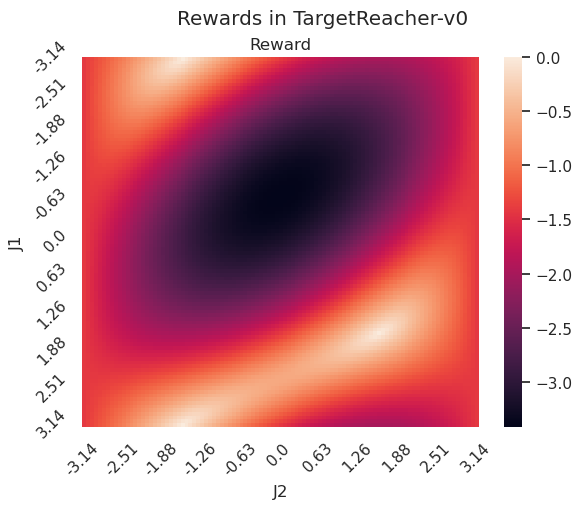

In [19]:
# Create the reward plot
num_ticks = 10
tick_skip = max(1, npoints // num_ticks)
tick_shift = 2*np.pi/npoints/2
tick_points = np.arange(npoints)[::tick_skip] + tick_shift
tick_labels = state_range.round(2)[::tick_skip]

sns.heatmap(rewards)
plt.xticks(tick_points, tick_labels, rotation=45)
plt.yticks(tick_points, tick_labels, rotation=45)
plt.xlabel("J2")
plt.ylabel("J1")
plt.title("Reward")
plt.suptitle("Rewards in %s" % env_name)
plt.show()


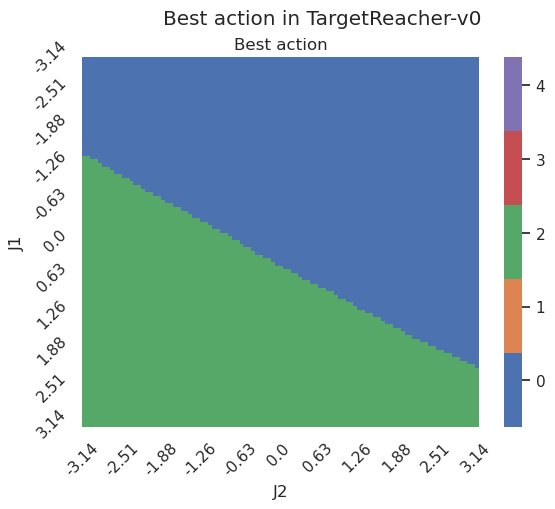

In [20]:
# # Create the policy plot
cmap = sns.color_palette("deep", action_space_dim)
sns.heatmap(actions, cmap=cmap, vmin=0, vmax=action_space_dim-1)
plt.xticks(tick_points, tick_labels, rotation=45)
plt.yticks(tick_points, tick_labels, rotation=45)
colorbar = plt.gca().collections[0].colorbar
ticks = np.array(range(action_space_dim))*((action_space_dim-1)/action_space_dim)+0.5
colorbar.set_ticks(ticks)
if env.spec.id == "Reacher-v1":
    # In Reacher, we can replace 0..4 with more readable labels
    labels = ["J1+", "J1-", "J2+", "J2-", "Stop"]
else:
    labels = list(map(str, range(action_space_dim)))
colorbar.set_ticklabels(labels)
plt.xlabel("J2")
plt.ylabel("J1")
plt.title("Best action")
plt.suptitle("Best action in %s" % env_name)
plt.show()

<a id='3.2.1'></a>
<div class=" alert alert-warning">
    <h3><b>Student Question 4.1</b> Achieved Performance (5 points) </h3> 

Where are the highest and lowest reward achieved?
            
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>


In [22]:
# Find highest and lowest reward state
# min and max are reversed because the reward is negative
max_idx = np.unravel_index(np.argmin(rewards), rewards.shape)
min_idx = np.unravel_index(np.argmax(rewards), rewards.shape)

max_state = np.array([state_range[max_idx[0]], state_range[max_idx[1]]])
min_state = np.array([state_range[min_idx[0]], state_range[min_idx[1]]])

print("Maximum value state:", max_state)
print("Minimum value state:", min_state)

Maximum value state: [-8.1681409e-01  4.4408921e-16]
Minimum value state: [-3.14159265 -1.57079633]


The highest reward is achieved at the region with darkest color and the lowest reward is achieved at the region with lightest color in the rewards in Reacher-v1 graph. By some python code, I can determine that the state with highest reward is [-8.1681409e-01  4.4408921e-16] and the state with lowest reward is [-3.14159265 -1.57079633]

<a id='Q5'></a>
<div class=" alert alert-warning">
    <h3><b>Student Question 4.2</b> Analysis of Behaviour (10 points) </h3> 

Did the policy learn to reach the goal from every possible state (manipulator configuration) in an optimal way (i.e. with lowest possible number of steps)? Why/why not?
            
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>

In the best action in TargetReacher-v1 plot, we can see that the model only recognizes two actions, 0 and 2, which correspond to increasing values of two rotating joint angular parameters $\theta_0$ and $\theta_1$. This means that the model is always rotating anticlockwise. This behavior is optimal when the initial state is close to the goal in anticlockwise direction. However, this policy will not reach the goal in an optimal way if the initial state has the goal in the clockwise direction from the reacher. This is because the reacher will instead rotate anticlockwise in the long way to reach the goal instead of choosing the shorter way by rotating clockwise. This is because the actions 1 and 3 are never recognized in this policy.

# 4. Submitting <a id='4.'></a>
Ensure all tasks and questions (in ```ex1.ipynb```) are answered and the relevant plots are recorded in the relevant places. Details about attaching images and figures can be found below. The relevant graphs to be included for this assignment are:
- Task 1, WandB CartPole ```episodesep_reward``` plot
- x2 Task 4 reward plots

Ensure the correct model files are saved:
- results/model/CartPole-v1_params.pt
- results/model/SpinningReacher-v0_params.pt
- results/model/TargetReacher-v0_params.pt

## 4.1 Feedback <a id='4.1'></a>
In order to help the staff of the course as well as the forthcoming students, it would be great if you could
answer feedback questionnaire in ```feedback.ipynb```

The assignment is not very difficult but the super frustrating thing is that the wandb server is constantly showing errors and I had to spend idle time waiting for the training to finish. Overall, Exercise 1 gives a gentle introduction plus the tools in RL. I rate it 8/10. 

Please use the following section to record references.
# References <a id='5.'></a>

I have no references in this exercise. 